In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as cpio
import os
import time

# Define the folder that contains all data files
# Each data file contains the variables:
#    s: The spectrogram [size = 513 x time_steps]
#    f: Frequencies [size = 513]
#    t: Time steps
#    labels: The tagging data [size = time_steps]
data_directory = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/mat'
# This folder must also contain a matlab file 'file_list.mat' with cell array 'keys' that holds the data file names
data_list = cpio.loadmat(data_directory + '/file_list.mat')
number_of_files = len(data_list['keys'][0])
# The folder for saving training checkpoints
training_records_dir = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/training_records'

In [2]:
# Parameters
input_vec_size = lstm_size = 513
batch_size = 101
n_lstm_layers = 2
n_syllables = 28 #including zero
learning_rate = 0.001
n_max_iter = 10001

In [3]:
# The inference graph
def label_inference_graph(spectrogram, num_hidden, num_layers, seq_length):
    # First the dynamic bi-directional, multi-layered LSTM
    with tf.name_scope('biRNN'): 
        with tf.variable_scope('fwd'):
            lstm_f1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_f2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_f3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_f = tf.contrib.rnn.MultiRNNCell([lstm_f1,lstm_f2], state_is_tuple=True)
        with tf.variable_scope('bck'):
            lstm_b1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_b2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_b3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_b = tf.contrib.rnn.MultiRNNCell([lstm_b1,lstm_b2], state_is_tuple=True)
        outputs, _states = tf.nn.bidirectional_dynamic_rnn(cells_f,cells, spectrogram, time_major=False, dtype=tf.float32,sequence_length=seq_length)
    # Second, projection on the number of syllables creates logits 
    with tf.name_scope('Projection'):
        W_f = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        W_b = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        bias = tf.Variable(tf.random_normal([n_syllables]))
    expr1 = tf.unstack(outputs[0],axis=0,num=batch_size)
    expr2 = tf.unstack(outputs[1],axis=0,num=batch_size)
    #logits = [tf.matmul(outputs[0][:,a,:],W_f) + bias + tf.matmul(outputs[1][:,a,:],W_b) for a in range(seq_length[0])]
    logits = tf.concat([tf.matmul(ex1,W_f) + bias + tf.matmul(ex2,W_b) for ex1,ex2 in zip(expr1,expr2)],0)
    return logits,outputs

In [4]:
# The training graph. Calculate cross entropy and loss function
def training_graph(logits, lbls, rate, lng):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = tf.concat(tf.unstack(lbls,axis=0,num=batch_size),0), name='xentropy') 
    cost = tf.reduce_mean(xentropy, name='cost')
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op, cost

In [5]:
# Construct the full graph and add saver
full_graph = tf.Graph()
with full_graph.as_default():
    # Generate placeholders for the spectrograms and labels.
    X = tf.placeholder("float", [None,None,input_vec_size], name = "Xdata") # holds spectrograms
    Y = tf.placeholder("int32",[None,None],name = "Ylabels") # holds labels
    lng = tf.placeholder("int32",name = "nSteps") # holds the sequence length
                                    
    tf.add_to_collection("specs", X)  # Remember this Op.
    tf.add_to_collection("labels", Y)  # Remember this Op.
    tf.add_to_collection("lng", lng)  # Remember this Op.

    # Build a Graph that computes predictions from the inference model.
    logits,outputs = label_inference_graph(X, lstm_size, n_lstm_layers, lng)
    tf.add_to_collection("logits", logits)  # Remember this Op.

    # Add to the Graph the Ops that calculate and apply gradients.
    train_op, cost = training_graph(logits, Y, learning_rate, lng) 
    
    # Add the variable initializer Op.
    init = tf.global_variables_initializer() #initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver(max_to_keep = 10)

In [6]:
# Train and save checkpoint at the end of each file.
with tf.Session(graph=full_graph,config = tf.ConfigProto(
    intra_op_parallelism_threads = batch_size)) as sess:
    # Run the Op to initialize the variables.
    sess.run(init)
    # Start the training loop.
    costs = []
    step = 1
    # Go over all training files
    file_num = 0
    fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
    data = cpio.loadmat(data_directory + '/' + fname)
    data1 = np.transpose(data['s'])
    intY = data['labels'][0]
    for file_num in range(number_of_files-1):
        # load current training file
        fname = data_list['keys'][0][file_num+1][0][0:-3]+'mat'
        bdata = cpio.loadmat(data_directory + '/' + fname)
        bdata1 = np.transpose(bdata['s'])
        bintY = bdata['labels'][0]
        data1 = np.concatenate((data1,bdata1),axis = 0)
        intY = np.concatenate((intY,bintY),axis = 0)
    temp_n = len(intY)/batch_size
    data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
    intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
    iter_order = np.random.permutation(data1.shape[1]-370)
    if (len(iter_order) > n_max_iter):
        iter_order = iter_order[0:n_max_iter]
    print data1.shape, len(iter_order)
    for iternum in iter_order:
        d = {X: data1[:,iternum:iternum+100,:] ,Y: intY[:,iternum:iternum+100] ,lng:[100]*batch_size}
        _cost,_ = sess.run((cost,train_op),feed_dict = d)
        costs.append(_cost)
        print([step,iternum,_cost])
        step = step + 1
            
        if (step % 100 == 0):    
            checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=step)
            print np.mean(costs[-10:-1])
    checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)
        

(101, 620, 513) 250
[1, 133, 4.7702093]
[2, 58, 6.2990441]
[3, 115, 3.60216]
[4, 144, 3.3844957]
[5, 204, 2.5358846]
[6, 38, 1.7358085]
[7, 230, 1.3929291]
[8, 8, 1.1815116]
[9, 157, 1.2652613]
[10, 112, 1.2231426]
[11, 114, 1.0071509]
[12, 192, 0.71131742]
[13, 47, 0.74443352]
[14, 113, 0.63870019]
[15, 163, 0.56102383]
[16, 239, 0.56968153]
[17, 76, 0.57435787]
[18, 11, 0.57224011]
[19, 71, 0.49658978]
[20, 40, 0.48458454]
[21, 249, 0.44854602]
[22, 194, 0.34426579]
[23, 102, 0.41441154]
[24, 215, 0.33483991]
[25, 214, 0.30831599]
[26, 16, 0.39117071]
[27, 110, 0.32987255]
[28, 186, 0.26855922]
[29, 187, 0.25798756]
[30, 150, 0.27858585]
[31, 15, 0.30982912]
[32, 106, 0.24929562]
[33, 93, 0.23264398]
[34, 117, 0.21557473]
[35, 125, 0.20205656]
[36, 217, 0.26682132]
[37, 123, 0.18328482]
[38, 61, 0.22719581]
[39, 178, 0.18667486]
[40, 68, 0.19575034]
[41, 122, 0.18648686]
[42, 160, 0.19411753]
[43, 151, 0.18842819]
[44, 248, 0.21507673]
[45, 200, 0.1641589]
[46, 205, 0.1552988]
[47, 1

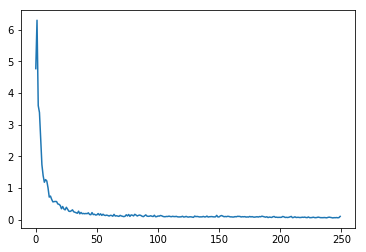

251

In [7]:
import pylab
pylab.figure()
pylab.plot(costs)
pylab.show()
step

In [8]:
# Evaluate training set from a saved checkpoint
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-200.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-200"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    errors = []
    for file_num in range(number_of_files):
        # load current training file
        fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
        data = cpio.loadmat(data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        intY = data['labels'][0]
        temp_n = len(intY)/batch_size
        data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
        intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
        d = {X: data1 ,Y: intY ,lng:[temp_n]*batch_size}
        pred = sess.run(eval_op,feed_dict = d)
        errors.append(np.abs(np.squeeze(pred[1]).reshape(-1)-intY.reshape(-1)) != 0)

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/training_records/checkpoint-200


In [9]:
# Results on training set
[np.mean(err) for err in errors]

[0.040914385556202679,
 0.041018387553041019,
 0.048583928160257889,
 0.049504950495049507,
 0.04064616988014591,
 0.062293729372937291,
 0.060764900019413703,
 0.035502121640735504,
 0.050647372429550648,
 0.037438118811881187,
 0.042772277227722776]

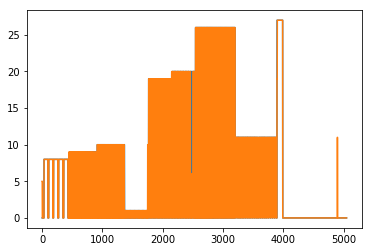

In [11]:
pylab.plot(intY.reshape(-1))
pylab.plot(np.squeeze(pred[1]).reshape(-1))
np.mean(np.abs(np.squeeze(pred[1]).reshape(-1)-intY.reshape(-1)) != 0)
pylab.show()